## Impact-oriented warnings from severity level forecasts

### Step 0: Load ensemble-based forecast data

In [66]:
import xarray as xr
import numpy as np

In [ ]:
# load "raw EWI severitylevel forecast [1-5] (demo subset for 5 leadtimes x 5 ensemble members)"
ds_severity = xr.load_dataset('ewi-wind-severitylevels-fordemo.nc')
ds_severity = ds_severity.squeeze()
ds_severity


/tmp/ipykernel_22056/3927944352.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_severity = xr.load_dataset('ewi-wind-severitylevels-fordemo.nc')


<xarray.Dataset> Size: 5MB
Dimensions:                  (lead_time: 5, x: 200, y: 135, realization: 5)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 40B 0 days 00:00:00 ...
  * x                        (x) float32 800B 2.461e+06 2.463e+06 ... 2.859e+06
  * y                        (y) float32 540B 1.051e+06 1.053e+06 ... 1.319e+06
    forecast_reference_time  datetime64[ns] 8B 2023-03-31
  * realization              (realization) int64 40B 0 1 2 3 4
    time                     (lead_time) datetime64[ns] 40B 2023-03-31 ... 20...
Data variables:
    severity                 (lead_time, y, x, realization) float64 5MB nan ....
Attributes:
    crs:      epsg:2056

### Step 1: Workaround: fuse ens x lead_time into one dimension

In [69]:
ds_severity_stacked = ds_severity.stack(lead_time_realization=("lead_time",
                                                               "realization"))
# need to reset index because climada hazard.from_xarray cannot handle multiindices
ds_severity_stacked = ds_severity_stacked.reset_index(
    "lead_time_realization", )

# make a convenience coordinate "lead_time_realization_label"
labels = xr.DataArray([
    f"lt_{l}_ens_{r}"
    for l, r in zip(ds_severity_stacked['lead_time'].values,
                    ds_severity_stacked['realization'].values)
],
                      dims="lead_time_realization")

ds_severity_stacked = ds_severity_stacked.assign_coords(
    lead_time_realization_label=labels)

# make a convenience coordinate "frequency" to account for ensembles manually
frequency = 1 / len(np.unique(ds_severity_stacked['realization'].values))
freq_array = xr.DataArray([frequency] *
                          ds_severity_stacked.dims['lead_time_realization'],
                          dims='lead_time_realization')

ds_severity_stacked = ds_severity_stacked.assign_coords(frequency=freq_array)

ds_severity_stacked

/tmp/ipykernel_22056/282254647.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds_severity_stacked.dims['lead_time_realization'],


<xarray.Dataset> Size: 5MB
Dimensions:                      (x: 200, y: 135, lead_time_realization: 25)
Coordinates:
  * x                            (x) float32 800B 2.461e+06 ... 2.859e+06
  * y                            (y) float32 540B 1.051e+06 ... 1.319e+06
    forecast_reference_time      datetime64[ns] 8B 2023-03-31
    time                         (lead_time_realization) datetime64[ns] 200B ...
    lead_time                    (lead_time_realization) timedelta64[ns] 200B ...
    realization                  (lead_time_realization) int64 200B 0 1 ... 3 4
    lead_time_realization_label  (lead_time_realization) <U36 4kB 'lt_0 nanos...
    frequency                    (lead_time_realization) float64 200B 0.2 ......
Dimensions without coordinates: lead_time_realization
Data variables:
    severity                     (y, x, lead_time_realization) float64 5MB na...
Attributes:
    crs:      epsg:2056

### Step 2: load into climada Hazard Object

In [71]:
from climada.hazard import Hazard

haz = Hazard.from_xarray_raster(
    ds_severity_stacked,
    hazard_type='severitylevel',
    intensity_unit=ds_severity_stacked['severity'].attrs['unit'],
    intensity='severity',
    data_vars={
        'event_name': 'lead_time_realization_label',
        'frequency': 'frequency'
    },
    coordinate_vars=dict(longitude="x", latitude="y", event='time'),
    crs=ds_severity_stacked.attrs['crs'])

haz.centroids.to_default_crs()
haz.check()


### Step 3: Load exposures & vulnerability functions

In [54]:
from climada.entity.exposures import Exposures
from climada.entity.exposures.litpop import LitPop

# Population
exp_che = LitPop.from_population(countries=['CHE', 'LIE'], res_arcsec=30)

array([[<Axes: title={'center': 'severitylevel 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
        <Axes: title={'center': 'severitylevel 3: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'severitylevel 4: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
        <Axes: title={'center': 'severitylevel 5: '}, xlabel='Intensity ()', ylabel='Impact (%)'>]],
      dtype=object)

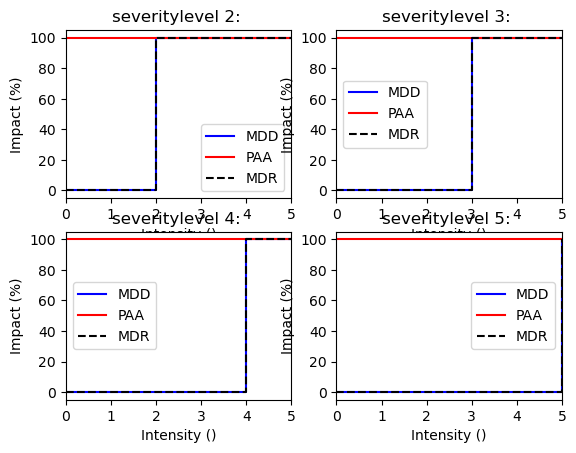

In [ ]:
from climada.entity import ImpactFunc, ImpactFuncSet

# Step functions mapping severity levels 
imp_fun_2 = ImpactFunc.from_step_impf((0, 2, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=2)
imp_fun_3 = ImpactFunc.from_step_impf((0, 3, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=3)
imp_fun_4 = ImpactFunc.from_step_impf((0, 4, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=4)
imp_fun_5 = ImpactFunc.from_step_impf((0, 5, 5),
                                      haz_type=f'{haz.haz_type}',
                                      impf_id=5)

impf_set_levels = ImpactFuncSet([imp_fun_2, imp_fun_3, imp_fun_4, imp_fun_5])
impf_set_levels.plot()

### Step 4: Compute impacts on fused Hazard Object

In [73]:
from climada.engine import ImpactCalc

# Impacts population - on "max" hazard (rep. for entire forecast period)
dict_imp_pop = {}

for level in range(2, 6):
    exp_che.gdf[f'impf_{haz.haz_type}'] = level
    dict_imp_pop[level] = ImpactCalc(exp_che, impf_set_levels,
                                     haz).impact(save_mat=True)


In [80]:
dict_imp_pop[2].imp_mat

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 321211 stored elements and shape (25, 70525)>